#Clasificación de reseñas utilizando Regresión Logística

## Paso 1: Cargar librerías y módulos requeridos

In [1]:
!pip install contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 5.6 MB/s eta 0:00:00


In [2]:
import pandas as pd #Biblioteca para manejar tablas de datos
import numpy as np #Biblioteca para manejar matrices y operaciones de matrices

#Preprocesamiento de texto
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer #SnowballStemmer (para español)
import contractions
nltk.download('stopwords')
nltk.download('wordnet') #WordNetLemmatizer

#Construccion de bolsas de palabras (Bag of Words)
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

#Librerías de Sklearn para Ciencia de Datos
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.preprocessing import MinMaxScaler





[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


##Paso 2: Definir funciones para el preprocesamiento de textos


In [ ]:
#Elimina stopwords
def elimina_stopwords(texto):
  stop = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
  nuevo_texto = stop.sub('', texto)
  return nuevo_texto

In [ ]:
#Elimina puntuacion y números
def elimina_puntuacion_y_numeros(texto):
  nuevo_texto = re.sub('[^a-z]+', ' ', texto)
  return nuevo_texto

In [ ]:
#Lemmatizer
def lematizar(texto):
  lemma = WordNetLemmatizer()
  texto = texto.split()
  texto2 = " ".join([lemma.lemmatize(i, 'v') for i in texto])
  nuevo_texto = " ".join([lemma.lemmatize(i, 'v') for i in texto])
  return nuevo_texto

In [ ]:
#Stemmmer
def stemmer(texto):
  st = PorterStemmer()
  texto = texto.split()
  nuevo_texto = ' '.join([st.stem(i) for i in texto])

  ## Para ESPAÑOL
  # st = SnowballStemmer("spanish")
  # texto = texto.split()
  # nuevo_texto = ' '.join([st.stem(i) for i in texto])

  return nuevo_texto

In [ ]:
def preprocesar(texto):
  texto = contractions.fix(texto)
  texto = texto.lower()
  texto = elimina_stopwords(texto)
  texto = elimina_puntuacion_y_numeros(texto)
  texto = stemmer(texto)
  return(texto)

In [ ]:
def evaluación(modelo, conjunto):
    mensaje_error = 'conjunto solo puede ser "entrenamieonto" o "prueba"'
    assert conjunto in ['entrenamiento', 'prueba'], mensaje_error


    if conjunto == 'entrenamiento':
      X = X_train
      y = y_train
    else:
      X = X_test
      y = y_test


    y_pred = modelo.predict(X)
    precision = accuracy_score(y, y_pred)*100

    #Creamos un diccionario con las etiquetas
    data = {'y_Real':  y,
            'y_Prediccion': y_pred
            }
    #Lo convertimos en un DataFrame de pandas
    df = pd.DataFrame(data, columns=['y_Real','y_Prediccion'])

    #Hacemos una tabla crusada para obtener la matriz de confusión
    confusion_matrix = pd.crosstab(df['y_Real'], df['y_Prediccion'],
                                   rownames=['Real'], colnames=['Predicción'])

    #Realizamos un mapa de calor
    titulo = 'Datos:{}, precisión = {:4.2f}'.format(conjunto, precision)
    sns.heatmap(confusion_matrix, annot=True, fmt='g').set(title = titulo)
    plt.show()


In [ ]:
#Gráfica Roc
def grafica_roc(clf, y_test):
    '''Grafica la curva ROC para el conjunto de prueba'''
    y_test_score = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve( y_test, y_test_score)
    roc_auc = auc(fpr, tpr)  #Area bajo la curva (AUC, por sus siglas en inglés)
    plt.figure()
    plt.plot(fpr, tpr, label="Curva ROC (area = %0.2f)" % roc_auc)
    plt.plot([0, 1], [0, 1], "--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate ")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic")
    plt.legend(loc="lower right")
    plt.show()

## Paso 3: Cargar datos y su lectura



In [3]:
#Vamos a cargar los datos con Pandas
datos = pd.read_csv('https://raw.githubusercontent.com/ElAleph25/Projectos-del-Portafolio-/main/Regresi%C3%B3nLog%C3%ADstica/deceptive-opinion.csv',
                     usecols=['deceptive','text']
                    )
print(datos.shape)
datos.head()

(1600, 2)


,deceptive,text
0,truthful,We stayed for a one night getaway with family ...
1,truthful,Triple A rate with upgrade to view room was le...
2,truthful,This comes a little late as I'm finally catchi...
3,truthful,The Omni Chicago really delivers on all fronts...
4,truthful,I asked for a high floor away from the elevato...


In [ ]:
#Veamos la información de nuestro DataFrame
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600 entries, 0 to 1599
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   deceptive  1600 non-null   object
 1   text       1600 non-null   object
dtypes: object(2)
memory usage: 25.1+ KB


In [ ]:
datos.deceptive.value_counts()

,count
deceptive,
truthful,800
deceptive,800


In [ ]:
y = datos['deceptive']

##Paso 5: Preprocesamiento de texto

In [ ]:
#Estos son los textos del corpus
datos['text']

,text
0,We stayed for a one night getaway with family ...
1,Triple A rate with upgrade to view room was le...
2,This comes a little late as I'm finally catchi...
3,The Omni Chicago really delivers on all fronts...
4,I asked for a high floor away from the elevato...
...,...
1595,Problems started when I booked the InterContin...
1596,The Amalfi Hotel has a beautiful website and i...
1597,The Intercontinental Chicago Magnificent Mile ...
1598,"The Palmer House Hilton, while it looks good i..."


In [ ]:
#¿Cuánto miden nuestros textos?
datos['long_text'] = datos['text'].str.split().str.len()
datos

,deceptive,text,long_text
0,truthful,We stayed for a one night getaway with family ...,105
1,truthful,Triple A rate with upgrade to view room was le...,45
2,truthful,This comes a little late as I'm finally catchi...,207
3,truthful,The Omni Chicago really delivers on all fronts...,127
4,truthful,I asked for a high floor away from the elevato...,72
...,...,...,...
1595,deceptive,Problems started when I booked the InterContin...,131
1596,deceptive,The Amalfi Hotel has a beautiful website and i...,121
1597,deceptive,The Intercontinental Chicago Magnificent Mile ...,141
1598,deceptive,"The Palmer House Hilton, while it looks good i...",86


In [ ]:
#Algunas estadísticas de nuestro DataFrame
datos['long_text'].describe()

,long_text
count,1600.000000
mean,148.775000
std,87.335984
min,25.000000
25%,88.000000
50%,128.000000
75%,182.250000
max,784.000000


In [ ]:
#¿Cuál es el texto más largo de nuestro corpus?
datos[datos['long_text']==784]

,deceptive,text,long_text
1473,deceptive,"For a hotel rated with four diamonds by AAA, o...",784


Los pasos clásicos en el preprocesamiento de textos
en el $\textit{Procesamiento del Lenguaje Natural}$ son:

- Convertir palabras a minúsculas.
- Quitar $\textit{stopwords}$.
- Quitar puntuación.
- Quitar números.
- Quitar espacios en blanco.

Normalizar un texto, consiste en realizar la técnica de $\textit{lematización}$ o $\textit{stemming}$ (radicalización) en los textos.

Referencia:
https://towardsdatascience.com/introduction-to-nlp-part-2-difference-between-lemmatisation-and-stemming-3789be1c55bc



###Ejemplo


Se hará un ejemplo particular de la aplicación de las funciones recurrentes en el procesamiento de texto.

In [ ]:
#Elegimos un texto del corpus
indice = 1500
ejemplo = datos.loc[indice, 'text']
ejemplo

"I stayed this hotel for 2 nights. I had high hopes seeing as this is a 4 star hotel and seems quite elegant based on pictures I've seen. Upon entering the building, you can easily see that it is clean and high class. The lobby was nice, and everything seemed as it should be. However, as soon as I made it into my room, it was completely different than everything previous to it. It was dirty, visible yellow stains on the walls and all around the restroom. The room too was not completely organized as all other hotel rooms I've been to. There was also a lingering smell from the last tenants. When I called the front desk about these issues, they sent someone up to fix it. I left the hotel about two hours and upon returning, they were still at it! This is an unreasonable amount of time to fix these glaring errors. The smell also did not completely disappear when they were done. As I was too tired, I just decided to deal with it for the rest of my stay here and focus on enjoying my vacation 

In [ ]:
#Se contrae el texto
ejemplo = contractions.fix(ejemplo)
ejemplo

'I stayed this hotel for 2 nights. I had high hopes seeing as this is a 4 star hotel and seems quite elegant based on pictures I have seen. Upon entering the building, you can easily see that it is clean and high class. The lobby was nice, and everything seemed as it should be. However, as soon as I made it into my room, it was completely different than everything previous to it. It was dirty, visible yellow stains on the walls and all around the restroom. The room too was not completely organized as all other hotel rooms I have been to. There was also a lingering smell from the last tenants. When I called the front desk about these issues, they sent someone up to fix it. I left the hotel about two hours and upon returning, they were still at it! This is an unreasonable amount of time to fix these glaring errors. The smell also did not completely disappear when they were done. As I was too tired, I just decided to deal with it for the rest of my stay here and focus on enjoying my vacat

In [ ]:
#Se transforma a minúsculas el texto
ejemplo = ejemplo.lower()
ejemplo

'i stayed this hotel for 2 nights. i had high hopes seeing as this is a 4 star hotel and seems quite elegant based on pictures i have seen. upon entering the building, you can easily see that it is clean and high class. the lobby was nice, and everything seemed as it should be. however, as soon as i made it into my room, it was completely different than everything previous to it. it was dirty, visible yellow stains on the walls and all around the restroom. the room too was not completely organized as all other hotel rooms i have been to. there was also a lingering smell from the last tenants. when i called the front desk about these issues, they sent someone up to fix it. i left the hotel about two hours and upon returning, they were still at it! this is an unreasonable amount of time to fix these glaring errors. the smell also did not completely disappear when they were done. as i was too tired, i just decided to deal with it for the rest of my stay here and focus on enjoying my vacat

In [ ]:
#Se eliminan las puntuaciones y numeraciones
ejemplo = elimina_puntuacion_y_numeros(ejemplo)
ejemplo

'i stayed this hotel for nights i had high hopes seeing as this is a star hotel and seems quite elegant based on pictures i have seen upon entering the building you can easily see that it is clean and high class the lobby was nice and everything seemed as it should be however as soon as i made it into my room it was completely different than everything previous to it it was dirty visible yellow stains on the walls and all around the restroom the room too was not completely organized as all other hotel rooms i have been to there was also a lingering smell from the last tenants when i called the front desk about these issues they sent someone up to fix it i left the hotel about two hours and upon returning they were still at it this is an unreasonable amount of time to fix these glaring errors the smell also did not completely disappear when they were done as i was too tired i just decided to deal with it for the rest of my stay here and focus on enjoying my vacation at chicago instead i

In [ ]:
#Se eliminan las "palabras irrelevantes"
ejemplo = elimina_stopwords(ejemplo)
ejemplo

'stayed hotel nights high hopes seeing star hotel seems quite elegant based pictures seen upon entering building easily see clean high class lobby nice everything seemed however soon made room completely different everything previous dirty visible yellow stains walls around restroom room completely organized hotel rooms also lingering smell last tenants called front desk issues sent someone fix left hotel two hours upon returning still unreasonable amount time fix glaring errors smell also completely disappear done tired decided deal rest stay focus enjoying vacation chicago instead hope shallow exterior fool others like fooled '

In [ ]:
#Ejemplo de lematización
ejemplo_lema = lematizar(ejemplo)
ejemplo_lema

'stay hotel nights high hop see star hotel seem quite elegant base picture see upon enter build easily see clean high class lobby nice everything seem however soon make room completely different everything previous dirty visible yellow stain wall around restroom room completely organize hotel room also linger smell last tenant call front desk issue send someone fix leave hotel two hours upon return still unreasonable amount time fix glare errors smell also completely disappear do tire decide deal rest stay focus enjoy vacation chicago instead hope shallow exterior fool others like fool'

In [ ]:
#Ejemplos de stemización
ejemplo_stem = stemmer(ejemplo)
ejemplo_stem

'stay hotel night high hope see star hotel seem quit eleg base pictur seen upon enter build easili see clean high class lobbi nice everyth seem howev soon made room complet differ everyth previou dirti visibl yellow stain wall around restroom room complet organ hotel room also linger smell last tenant call front desk issu sent someon fix left hotel two hour upon return still unreason amount time fix glare error smell also complet disappear done tire decid deal rest stay focu enjoy vacat chicago instead hope shallow exterior fool other like fool'

###Preprocesamiento para todos los textos

Aplicaremos todas las funciones anteriores en el procesamiento de todos los textos

In [ ]:
datos['text_pp'] = datos['text'].apply(preprocesar)
datos['long_text_pp'] = datos['text_pp'].str.split().str.len()
datos.head()

,deceptive,text,long_text,text_pp,long_text_pp
0,truthful,We stayed for a one night getaway with family ...,105,stay one night getaway famili thursday tripl a...,58
1,truthful,Triple A rate with upgrade to view room was le...,45,tripl rate upgrad view room less also includ b...,30
2,truthful,This comes a little late as I'm finally catchi...,207,come littl late final catch review past sever ...,104
3,truthful,The Omni Chicago really delivers on all fronts...,127,omni chicago realli deliv front spacious room ...,63
4,truthful,I asked for a high floor away from the elevato...,72,ask high floor away elev got room pleasantli d...,33


###Visualización de nubes de palabras

In [ ]:
def nube_palabras(sec_textos):
    # Crear la cadena con la que haremos la nube de palabras
    text= " ".join(review for review in sec_textos)

    # Crear la nube de palabras
    wordcloud = WordCloud( max_font_size=50,
                          max_words=100,
                          background_color="white").generate(text)

    # Desplegar la imagen generada
    plt.figure(figsize=[10,12])
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

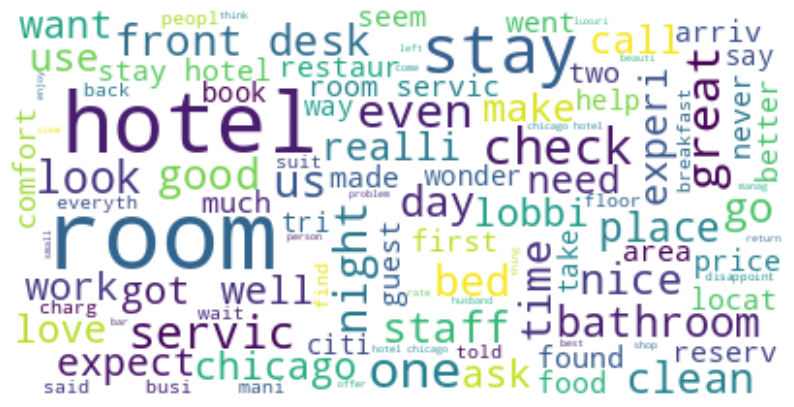

In [ ]:
#Nube total de las palabras
nube_palabras(datos['text_pp'])

In [ ]:
porClase = datos.groupby('deceptive')
verdaderas = porClase.get_group('truthful').text_pp
falsas = porClase.get_group('deceptive').text_pp

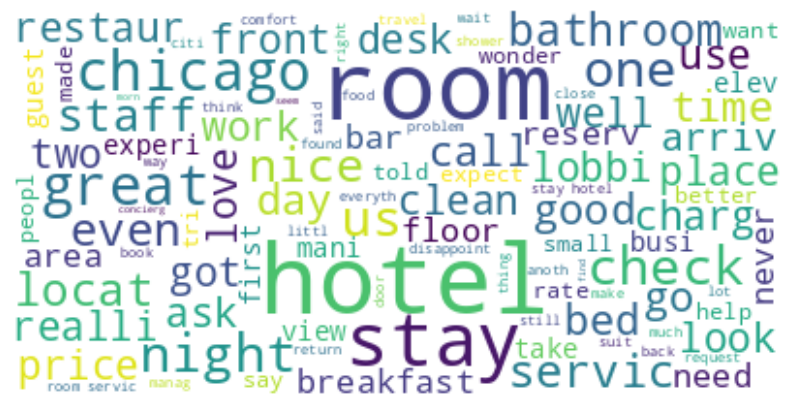

In [ ]:
#Palabras verdaderas
nube_palabras(verdaderas)

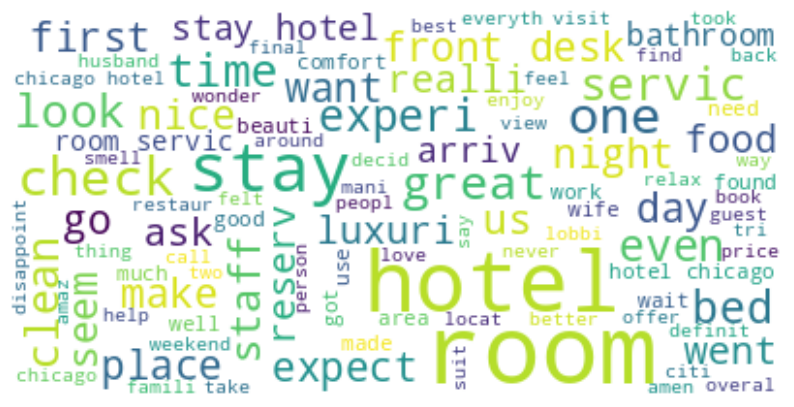

In [ ]:
#Palabras falsas
nube_palabras(falsas)

##Paso 6: Bolsas de palabras y TF-IDF


Se usará la funcion **```TFidfVectorizer```** de sklearn. Notar que, el paramentro **```min_df```**, hace la función "cut-off" para no considerar los términos con poca frecuencia en el documento.

In [ ]:
vectorizer = TfidfVectorizer(min_df=2)
BOW = vectorizer.fit_transform(datos['text_pp'])
BOW.shape

(1600, 3597)

In [ ]:
BOW

<1600x3597 sparse matrix of type '<class 'numpy.float64'>'
	with 92334 stored elements in Compressed Sparse Row format>

In [ ]:
type(BOW)

scipy.sparse._csr.csr_matrix

In [ ]:
#Construyamos nuestro DataFrame con solo las características
palabras = vectorizer.get_feature_names_out()
X = pd.DataFrame(BOW.todense(), index=datos.index, columns=palabras)
X

,aaa,abil,abl,abrupt,absenc,absent,absolut,absurd,abund,abysm,...,york,young,younger,yr,yuck,yummi,yup,zest,zone,zoo
0,0.189205,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.08608,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1596,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1597,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1598,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##Paso 7: Regresión Logística sin penalización

En este paso, se utilizará la $\textit{Regresión Logística}$ para hacer una clasificación binaria supervisada de reseñas favorables.

In [ ]:
#Dividir datos en entrenamiento y prueba
X_train, X_test , y_train, y_test = train_test_split(X, y,
                                                     test_size=0.2,
                                                     shuffle=True,
                                                     random_state=9
                                                     )

clasificador_rl = LogisticRegression(penalty= None,
                                     random_state=4,
                                     solver="newton-cg").fit(X_train, y_train)

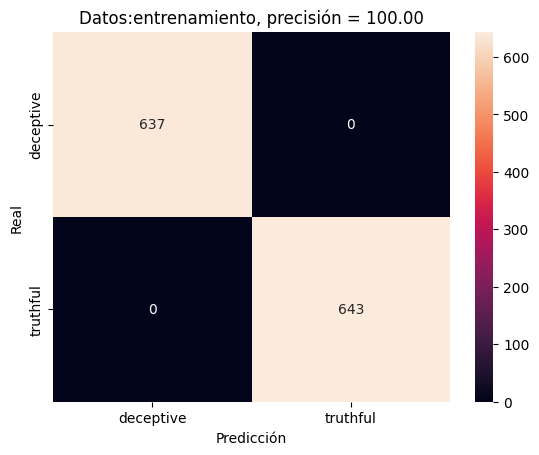

In [ ]:
#Evaluación en el entrenamiento
evaluación(clasificador_rl, 'entrenamiento')

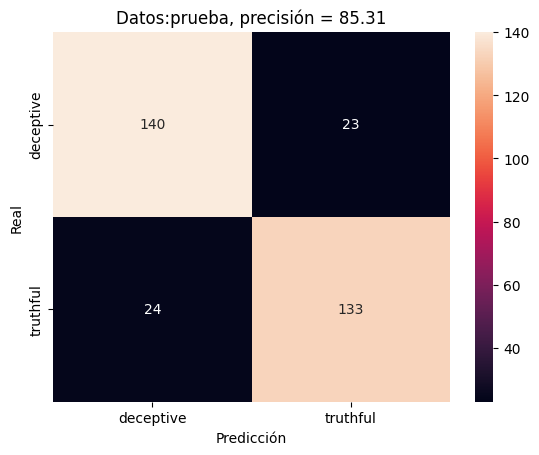

In [ ]:
#Evaluación en la prueba
evaluación(clasificador_rl, 'prueba')

##Paso 8: Regresión Logística con penalización Ridge

La $\textit{Regularización Logística Ridge}$ permite que el algoritmo de regresión evite mayoritariamente el sobre-ajuste.

Esto es, evitar que las variables aleatorias que generan a nuestro DataSet estén correlacionadas.

El error Ridge se define como $$\textit{error}_{\textit{Ridge},\beta}(x,y)=\textit{error}_{\textit{Log},\beta}(x,y)+\lambda\lVert\beta \rVert^2.$$

###¿De qué magnitud debe ser la fueza de la regularización (parámetro  $\lambda$)?

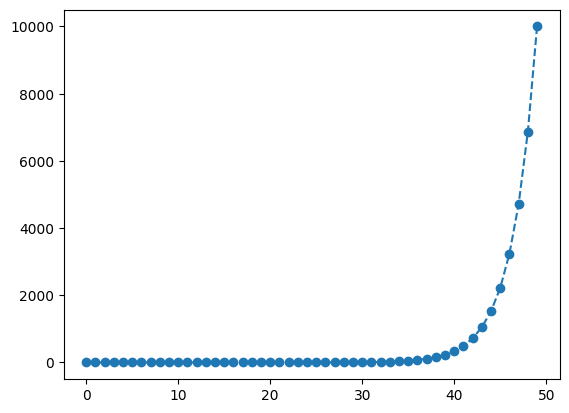

In [ ]:
lambdas = np.logspace(-4, 4, 50)
plt.plot(lambdas, linestyle='--', marker='o')
plt.show()

In [ ]:
lambdas

array([1.00000000e-04, 1.45634848e-04, 2.12095089e-04, 3.08884360e-04,
       4.49843267e-04, 6.55128557e-04, 9.54095476e-04, 1.38949549e-03,
       2.02358965e-03, 2.94705170e-03, 4.29193426e-03, 6.25055193e-03,
       9.10298178e-03, 1.32571137e-02, 1.93069773e-02, 2.81176870e-02,
       4.09491506e-02, 5.96362332e-02, 8.68511374e-02, 1.26485522e-01,
       1.84206997e-01, 2.68269580e-01, 3.90693994e-01, 5.68986603e-01,
       8.28642773e-01, 1.20679264e+00, 1.75751062e+00, 2.55954792e+00,
       3.72759372e+00, 5.42867544e+00, 7.90604321e+00, 1.15139540e+01,
       1.67683294e+01, 2.44205309e+01, 3.55648031e+01, 5.17947468e+01,
       7.54312006e+01, 1.09854114e+02, 1.59985872e+02, 2.32995181e+02,
       3.39322177e+02, 4.94171336e+02, 7.19685673e+02, 1.04811313e+03,
       1.52641797e+03, 2.22299648e+03, 3.23745754e+03, 4.71486636e+03,
       6.86648845e+03, 1.00000000e+04])

In [ ]:
%%time
from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(LogisticRegression(penalty='l2',solver="newton-cg"),
                           {'C': 1/lambdas}, cv=5, return_train_score=False)
grid_search.fit(X, y)

CPU times: user 3min 23s, sys: 1min 57s, total: 5min 21s
Wall time: 4min 41s


GridSearchCV(cv=5, estimator=LogisticRegression(solver='newton-cg'),
             param_grid={'C': array([1.00000000e+04, 6.86648845e+03, 4.71486636e+03, 3.23745754e+03,
       2.22299648e+03, 1.52641797e+03, 1.04811313e+03, 7.19685673e+02,
       4.94171336e+02, 3.39322177e+02, 2.32995181e+02, 1.59985872e+02,
       1.09854114e+02, 7.54312006e+01, 5.17947468e+01, 3.55648031e+01,
       2.44205309e+01, 1.676...
       1.20679264e+00, 8.28642773e-01, 5.68986603e-01, 3.90693994e-01,
       2.68269580e-01, 1.84206997e-01, 1.26485522e-01, 8.68511374e-02,
       5.96362332e-02, 4.09491506e-02, 2.81176870e-02, 1.93069773e-02,
       1.32571137e-02, 9.10298178e-03, 6.25055193e-03, 4.29193426e-03,
       2.94705170e-03, 2.02358965e-03, 1.38949549e-03, 9.54095476e-04,
       6.55128557e-04, 4.49843267e-04, 3.08884360e-04, 2.12095089e-04,
       1.45634848e-04, 1.00000000e-04])})

In [ ]:
grid_search.best_params_

{'C': 5.4286754393238645}

In [ ]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.936889,0.286627,0.081162,0.004750,10000.0,{'C': 10000.0},0.868750,0.834375,0.890625,0.850000,0.812500,0.851250,0.026998,26
1,2.315473,0.548156,0.089332,0.024238,6866.48845,{'C': 6866.488450042998},0.868750,0.834375,0.893750,0.853125,0.812500,0.852500,0.027909,21
2,1.949418,0.420509,0.073447,0.027865,4714.866363,{'C': 4714.866363457394},0.868750,0.831250,0.893750,0.853125,0.812500,0.851875,0.028339,24
3,1.639262,0.107057,0.073389,0.029205,3237.457543,{'C': 3237.4575428176436},0.868750,0.828125,0.893750,0.853125,0.812500,0.851250,0.028818,26
4,2.048186,0.154442,0.085143,0.011704,2222.996483,{'C': 2222.9964825261955},0.868750,0.828125,0.890625,0.856250,0.815625,0.851875,0.027143,25
5,1.918165,0.407971,0.076219,0.040571,1526.417967,{'C': 1526.4179671752333},0.868750,0.828125,0.890625,0.856250,0.818750,0.852500,0.026324,21
6,1.041947,0.108233,0.045264,0.010807,1048.113134,{'C': 1048.1131341546852},0.868750,0.828125,0.890625,0.856250,0.821875,0.853125,0.025541,20
7,1.918323,0.687212,0.071803,0.033632,719.685673,{'C': 719.6856730011522},0.871875,0.828125,0.893750,0.856250,0.821875,0.854375,0.026853,19
8,1.935004,0.627764,0.112734,0.045256,494.171336,{'C': 494.1713361323838},0.868750,0.828125,0.900000,0.856250,0.825000,0.855625,0.027698,18
9,2.009934,0.148228,0.110125,0.026163,339.322177,{'C': 339.32217718953297},0.865625,0.831250,0.903125,0.859375,0.825000,0.856875,0.027909,16


In [ ]:
C = grid_search.best_params_['C']

# valor de lambda
1 / grid_search.best_params_['C']

0.18420699693267145

In [ ]:
clasificador_ridge = LogisticRegression(penalty= 'l2',
                                        # C = C,
                                        C = 5.4286754393238645,
                                        random_state=4,
                                        solver="newton-cg").fit(X_train, y_train)

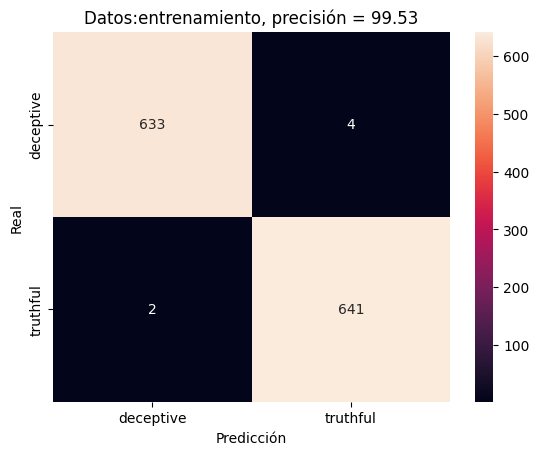

In [ ]:
evaluación(clasificador_ridge, 'entrenamiento')

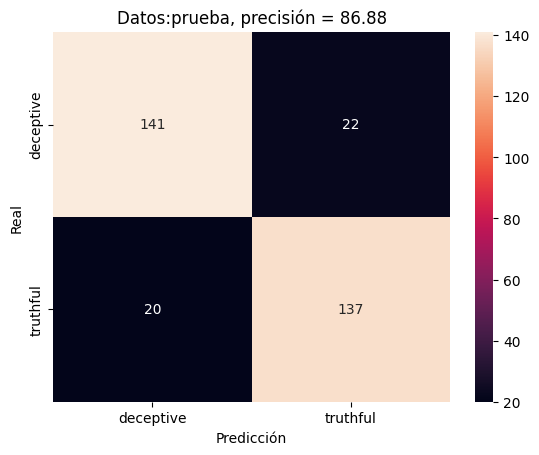

In [ ]:
evaluación(clasificador_ridge, 'prueba')

##Paso 9: Predicciones y certeza de la predicción

In [ ]:
resultados = {'P(deceptive)' : clasificador_ridge.predict_proba(X_test)[:,0],
              'P(truthful)' : clasificador_ridge.predict_proba(X_test)[:,1],
              'y_pred_50' : clasificador_ridge.predict(X_test),
              }

predicciones = pd.DataFrame(resultados)
predicciones.sort_values('P(deceptive)',
                         ascending=False).iloc[125:165]

,P(deceptive),P(truthful),y_pred_50
297,0.652506,0.347494,deceptive
24,0.650253,0.349747,deceptive
22,0.645439,0.354561,deceptive
264,0.634577,0.365423,deceptive
295,0.633022,0.366978,deceptive
4,0.624395,0.375605,deceptive
100,0.608537,0.391463,deceptive
301,0.608218,0.391782,deceptive
244,0.604251,0.395749,deceptive
6,0.600574,0.399426,deceptive


In [ ]:
predicciones['y_pred_30'] = np.where( predicciones['P(deceptive)'] > 0.3, 'deceptive', 'truthful')
predicciones.sort_values('P(deceptive)',
                         ascending=False).iloc[125:165]

,P(deceptive),P(truthful),y_pred_50,y_pred_30
297,0.652506,0.347494,deceptive,deceptive
24,0.650253,0.349747,deceptive,deceptive
22,0.645439,0.354561,deceptive,deceptive
264,0.634577,0.365423,deceptive,deceptive
295,0.633022,0.366978,deceptive,deceptive
4,0.624395,0.375605,deceptive,deceptive
100,0.608537,0.391463,deceptive,deceptive
301,0.608218,0.391782,deceptive,deceptive
244,0.604251,0.395749,deceptive,deceptive
6,0.600574,0.399426,deceptive,deceptive


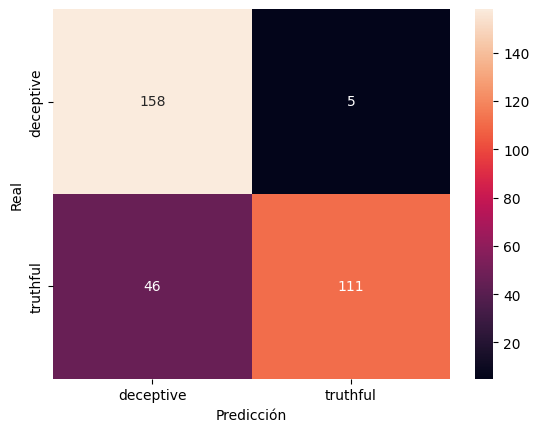

In [ ]:
#Creamos un diccionario con las etiquetas
data = {'y_Real':  y_test.to_numpy(),
        'y_Prediccion': predicciones['y_pred_30']
        }
#Lo convertimos en un DataFrame de Pandas
df = pd.DataFrame(data, columns=['y_Real','y_Prediccion'])

#Hacemos una tabla crusada para obtener la matriz de confusión
confusion_matrix = pd.crosstab(df['y_Real'], df['y_Prediccion'],
                                rownames=['Real'], colnames=['Predicción'])

#Realizamos un mapa de calor
sns.heatmap(confusion_matrix, annot=True, fmt='g')
plt.show()

###Grafica Roc
Área bajo la curva entre:

- True Positive Rate  (Sensitivity) :   Verdaderos Positivos / Positivos


- False Positive Rate (1-Specificity): Falsos Positivos / Negativos    


In [ ]:
ytest_bin = np.where(y_test=='deceptive', 0, 1)

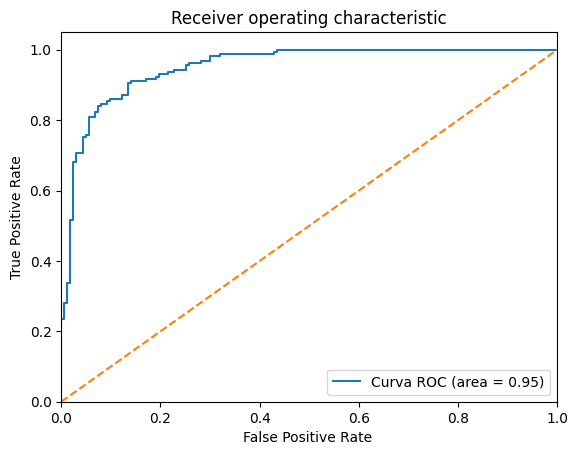

In [ ]:
grafica_roc(clasificador_ridge, ytest_bin)

In [ ]:
y_test_score = clasificador_ridge.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve( ytest_bin, y_test_score)

roc_df = pd.DataFrame({'fpr': fpr,
                       'tpr':tpr,
                       'umbral_decision': thresholds,
                       'distancia': np.sqrt((fpr)**2 + (1-tpr)**2),
                       })

roc_df

/usr/local/lib/python3.10/dist-packages/pandas/core/nanops.py:1010: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,fpr,tpr,umbral_decision,distancia
0,0.000000,0.000000,inf,1.000000
1,0.000000,0.006369,0.995444,0.993631
2,0.000000,0.235669,0.916022,0.764331
3,0.006135,0.235669,0.912105,0.764356
4,0.006135,0.280255,0.896960,0.719771
5,0.012270,0.280255,0.894004,0.719850
6,0.012270,0.337580,0.884294,0.662534
7,0.018405,0.337580,0.881681,0.662676
8,0.018405,0.515924,0.819500,0.484426
9,0.024540,0.515924,0.818633,0.484698


In [ ]:
roc_df.sort_values('distancia').head(1)

,fpr,tpr,umbral_decision,distancia
32,0.134969,0.904459,0.483377,0.165363


## Paso 10: Magnitud de los coeficientes para ambos modelos

In [ ]:
clasificador_rl.coef_[0].shape


(3597,)

In [ ]:
coeficientes_rl = pd.Series(clasificador_rl.coef_[0],
                            index=palabras,
                            name='Sin regularización').sort_values(ascending=False)
coeficientes_rl

,Sin regularización
floor,38.320207
street,36.821836
locat,34.552529
small,31.865226
elev,31.243518
...,...
recent,-27.625846
relax,-28.728548
millennium,-30.208334
luxuri,-40.941311


In [ ]:
coeficientes_ridge = pd.Series(clasificador_ridge.coef_[0],
                               index=palabras,
                               name='Ridge').sort_values(ascending=False)
coeficientes_ridge

,Ridge
floor,4.169108
locat,4.131653
elev,3.624349
small,3.526926
street,3.453209
...,...
millennium,-3.228035
relax,-3.261381
experi,-3.410476
luxuri,-5.182470


In [ ]:
coeficientes_ridge.min(), coeficientes_ridge.max()

(-7.7344425016311895, 4.1691083065408225)

In [ ]:
#Magnitudes de los coeficientes del modelo sin y con regularización Ridge
coef = pd.concat([coeficientes_rl, coeficientes_ridge], axis=1)
coef.sort_values(by='Ridge', ascending=False)

,Sin regularización,Ridge
floor,38.320207,4.169108
locat,34.552529,4.131653
elev,31.243518,3.624349
small,31.865226,3.526926
street,36.821836,3.453209
...,...,...
millennium,-30.208334,-3.228035
relax,-28.728548,-3.261381
experi,-25.652845,-3.410476
luxuri,-40.941311,-5.182470


In [ ]:
#Importancia de las palabras para predecir que es falsa la reseña
np.exp(coef).sort_values(by='Ridge', ascending=False)

,Sin regularización,Ridge
floor,4.387877e+16,64.657771
locat,1.013847e+15,62.280802
elev,3.705847e+13,37.500287
small,6.900681e+13,34.019242
street,9.806635e+15,31.601630
...,...,...
millennium,7.597790e-14,0.039635
relax,3.336954e-13,0.038335
experi,7.229544e-12,0.033025
luxuri,1.657351e-18,0.005614
